In [1]:
import sys
sys.path.append('..')

from deepgraph.utils.logging import log
from deepgraph.utils.common import batch_parallel, ConfigMixin, shuffle_in_unison_inplace, pickle_dump
from deepgraph.utils.image import batch_pad_mirror, rotate_transformer_scalar_float32, rotate_transformer_rgb_uint8
from deepgraph.constants import *
from deepgraph.conf import rng
from deepgraph.nn.core import Dropout

from deepgraph.pipeline import *

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 85.0% of memory, CuDNN 3007)




  _____                _____                 _
 |  _  \              |  __ \               | |
 | | | |___  ___ _ __ | |  \/_ __ __ _ _ __ | |__
 | | | / _ \/ _ \ '_ \| | __| '__/ _` | '_ \| '_ \
 | |/ /  __/  __/ |_) | |_\ \ | | (_| | |_) | | | |
 |___/ \___|\___| .__/ \____/_|  \__,_| .__/|_| |_|
                | |                   | |
                |_|                   |_|


Available on GitHub: https://github.com/sebastian-schlecht/deepgraph



In [2]:
import math

def build_checkerboard(w, h) :
    re = np.r_[ w*[0,1] ]        # even-numbered rows
    ro = np.r_[ w*[1,0] ]        # odd-numbered rows
    return np.row_stack(h*(re, ro))

class Checkboard(Processor):
    def __init__(self, name, shapes, config, buffer_size=10):
        super(Checkboard, self).__init__(name, shapes, config, buffer_size)
        self.mean = None

    def init(self):
        pass
    def process(self):
        packet = self.pull()
        # Return if no data is there
        if not packet:
            return False
        
        # Do processing
        log("Transformer - Processing data", LOG_LEVEL_VERBOSE)
        i_h = 228
        i_w = 304

        d_h = 228
        d_w = 304

        start = time.time()
        
        # Checkerboard to test conv autoencoder
        
        #data = build_checkerboard( 304/4, 228/4,).repeat(2, axis=0).repeat(2,axis=1).reshape(1,228,304).astype(np.float32)
        data = np.zeros((228, 304), dtype=np.float32)
        data[0:114,0:152] = 1.0
        data[114:,152:] = 1.0
        
        data = data.reshape(1,228,304)
        data = np.repeat(data[np.newaxis,:,:, :], 10, axis=0)
        label = data.copy()
        
        # Try to push into queue as long as thread should not terminate
        self.push(Packet(identifier=packet.id, phase=packet.phase, num=2, data=(data, label)))
        return True

In [3]:
from theano.tensor.nnet import relu

from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *

from deepgraph.pipeline import Optimizer, H5DBLoader, Pipeline


def build_graph():
    graph = Graph("unet")

    data            = Data(graph, "data", T.ftensor4, shape=(-1, 1, 228, 304))
    label           = Data(graph, "label", T.ftensor4, shape=(-1, 1, 228, 304), config={
        "phase": PHASE_TRAIN
    })
    
    conv_c1_1     = Conv2D(graph, "conv_1_1", config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": relu
        }
    )
    pool_c1 = Pool(graph, "pool_0", config={
        "kernel": (2, 2)
    })
    
    conv_c2_1     = Conv2D(graph, "conv_2_1", config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": relu,
            "is_output": True
        }
    )    
    up_e2 = Upsample(graph, "up_2", config={
            "kernel": (2, 2),
            "is_output": True
    })
    up_conv_e2 = Conv2D(graph, "up_conv_2", config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": 1,
            "activation": None
        }
    )
    
    conv_e_f= Conv2D(graph, "conv_e_f", config={
            "channels": 1,
            "kernel": (1, 1),
            "activation": None,
            "is_output": True
        }
    )
    
    
    
    loss            = EuclideanLoss(graph, "loss")

    error = MSE(graph, "mse", config={
        "root": True,
        "is_output": True,
        "phase": PHASE_TRAIN
    })

    # Connect
    data.connect(conv_c1_1)
    conv_c1_1.connect(pool_c1)
    pool_c1.connect(conv_c2_1)
    conv_c2_1.connect(up_e2)
    up_e2.connect(up_conv_e2)
    up_conv_e2.connect(conv_e_f)
    
    
    conv_e_f.connect(loss)
    conv_e_f.connect(error)
    
    label.connect(loss)
    label.connect(error)
    
    

    return graph

In [4]:
if __name__ == "__main__":

    batch_size = 5
    chunk_size = 2*batch_size
    transfer_shape = ((chunk_size, 1, 228, 304), (chunk_size, 1, 228, 304))

    g = build_graph()

    # Build the training pipeline
    cb = Checkboard("cb", transfer_shape, config={
    })
    optimizer = Optimizer("opt", g, transfer_shape, config={
        "batch_size":  batch_size,
        "chunk_size": chunk_size,
        "learning_rate": 0.001,
        "momentum": 0.9,
        "weight_decay": 0,
        "print_freq": 100,
        "save_freq": 1000,
        # "weights": "../data/alexnet_combined_iter_10000.zip",
        "save_prefix": "../data/unet_test_two_paths_only_checkerboard"
    })

    p = Pipeline(config={
        "validation_frequency": 50,
        "cycles": 500 # 2 minibatches per cycle = 1000 iters
    })
    p.add(cb)
    p.add(optimizer)
    p.run()





[2016-04-11 17:46:02] INFO: Pipeline - Starting computation
[2016-04-11 17:46:02] INFO: Graph - Setting up graph
[2016-04-11 17:46:02] INFO: Node - data has shape (-1, 1, 228, 304)
[2016-04-11 17:46:02] INFO: Node - label has shape (-1, 1, 228, 304)
[2016-04-11 17:46:02] INFO: Node - conv_1_1 has shape (-1, 64, 228, 304)
[2016-04-11 17:46:02] INFO: Node - pool_0 has shape (-1, 64, 114, 152)
[2016-04-11 17:46:02] INFO: Node - conv_2_1 has shape (-1, 128, 114, 152)
[2016-04-11 17:46:02] INFO: Node - up_2 has shape (-1, 128, 228, 304)
[2016-04-11 17:46:02] INFO: Node - up_conv_2 has shape (-1, 64, 228, 304)
[2016-04-11 17:46:02] INFO: Node - conv_e_f has shape (-1, 1, 228, 304)
[2016-04-11 17:46:02] INFO: Node - loss has shape (1,)
[2016-04-11 17:46:02] INFO: Node - mse has shape (1,)
[2016-04-11 17:46:02] INFO: Graph - Invoking Theano compiler
[2016-04-11 17:46:09] INFO: Optimizer - Compilation finished
[2016-04-11 17:46:31] INFO: Optimizer - Training score at iteration 100: {'loss': arr

In [ ]:
# Check gradients
# g.last_updates[16].get_value()

In [5]:
e = build_graph()
e.load_weights("../data/unet_test_two_paths_only_checkerboard_iter_1000.zip")
e.compile()

[2016-04-11 17:51:00] INFO: Graph - Loading parameters from file '../data/unet_test_two_paths_only_checkerboard_iter_1000.zip'
[2016-04-11 17:51:00] INFO: Graph - Setting up graph
[2016-04-11 17:51:00] INFO: Node - data has shape (-1, 1, 228, 304)
[2016-04-11 17:51:00] INFO: Node - label has shape (-1, 1, 228, 304)
[2016-04-11 17:51:00] INFO: Node - conv_1_1 has shape (-1, 64, 228, 304)
[2016-04-11 17:51:00] INFO: Node - pool_0 has shape (-1, 64, 114, 152)
[2016-04-11 17:51:00] INFO: Node - conv_2_1 has shape (-1, 128, 114, 152)
[2016-04-11 17:51:00] INFO: Node - up_2 has shape (-1, 128, 228, 304)
[2016-04-11 17:51:00] INFO: Node - up_conv_2 has shape (-1, 64, 228, 304)
[2016-04-11 17:51:00] INFO: Node - conv_e_f has shape (-1, 1, 228, 304)
[2016-04-11 17:51:00] INFO: Node - loss has shape (1,)
[2016-04-11 17:51:00] INFO: Node - mse has shape (1,)
[2016-04-11 17:51:00] INFO: Graph - Invoking Theano compiler


0.499792


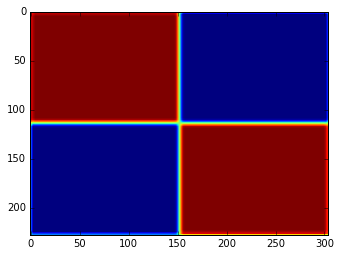

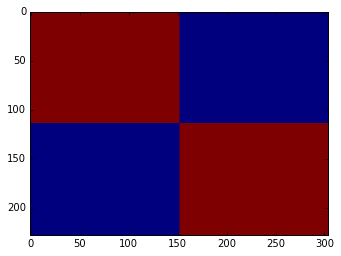

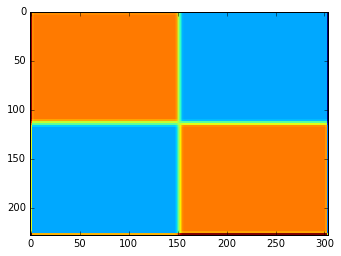

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout
w = 304
h = 228
Dropout.set_dp_off()

data = np.zeros((228, 304), dtype=np.float32)
data[0:114,0:152] = 1.0
data[114:,152:] = 1.0

data = data.reshape(1,228,304)
data = np.repeat(data[np.newaxis,:,:, :], 1, axis=0)
res = e.infer([data])
o = res["conv_e_f"].squeeze()
plt.imshow(o)
print o.mean()
plt.show()
plt.imshow(data.squeeze())
plt.show()
f_idx = 5
u = res["up_2"].squeeze()[f_idx]
plt.imshow(u)
plt.show()



    

0.141605


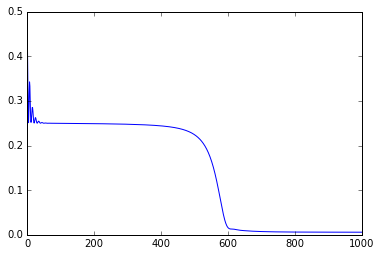

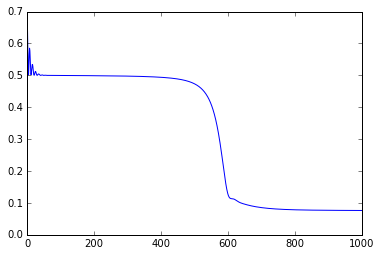

In [8]:
%matplotlib inline
import six.moves.cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
a = pickle.load(open("../data/unet_test_two_paths_only_checkerboard_iter_1000_loss.pkl", "rb"))
l = np.array([s["loss"] for s in a])
e = np.array([s["mse"] for s in a])
print l.mean()
plt.plot(l)
plt.show()
plt.plot(e)
plt.show()